In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [2]:
with open('exonerations.xlsx','rb') as fin:
    df = pd.read_excel(fin, 
                  names = ['lastname','firstname','age','race','sex','state',
                          'county','tags','wcd','lacr','yr_o','yr_c','yr_e',
                          'sentence','dna','star','fc','mwid','f/mfe','p/fa',
                          'om','ild','postdate','id'])

Use `pd.DataFrame.groupby` to combine or split the data.

The `by` argument can be a mapping, function, label, or list of labels.

Returns a `DataFrameGroupBy` object.

In [3]:
df_race = df.groupby(['race'])

print(type(df_race))
races = df['race'].unique()
print(races)

<class 'pandas.core.groupby.groupby.DataFrameGroupBy'>
['Black' 'White' 'Hispanic' 'Other' 'Asian' 'Native American']


In [4]:
df_race.get_group(races[0])

df_race.count()

,lastname,firstname,age,sex,state,county,tags,wcd,lacr,yr_o,...,dna,star,fc,mwid,f/mfe,p/fa,om,ild,postdate,id
race,,,,,,,,,,,,,,,,,,,,,
Asian,23,23,23,23,23,19,21,23,7,23,...,1,0,0,2,4,8,9,9,23,23
Black,1167,1167,1163,1167,1167,1151,1017,1167,538,1167,...,286,59,150,429,248,669,658,294,1167,1167
Hispanic,283,283,282,283,283,279,250,283,86,283,...,37,10,30,96,41,159,147,86,283,283
Native American,18,18,18,18,18,18,17,18,8,18,...,4,2,4,8,6,11,9,4,18,18
Other,15,15,15,15,15,13,11,15,6,15,...,1,1,1,4,3,7,5,4,15,15
White,914,914,913,914,914,894,849,914,338,914,...,161,53,109,145,257,556,469,218,914,914


In [5]:
df['time_elapsed'] = df['yr_e'] - df['yr_c']
longest = df['time_elapsed'].unique().max()

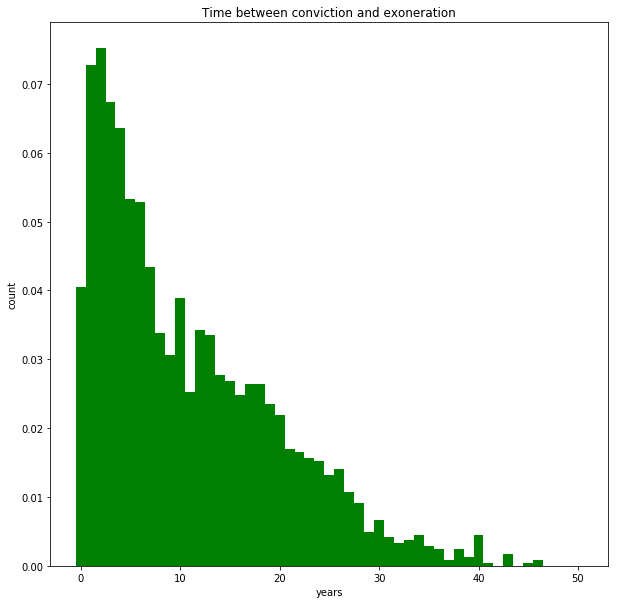

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
df.hist('time_elapsed', bins=np.arange(longest)-0.5, ax=ax,color='g',
       weights = np.ones_like(df['time_elapsed']) / len(df['time_elapsed']))
ax.set_title('Time between conviction and exoneration')
ax.set_xlabel('years')
ax.set_ylabel('count')
ax.grid(False)

plt.show()

In [7]:
df[df['time_elapsed']==longest]

,lastname,firstname,age,race,sex,state,county,tags,wcd,lacr,...,star,fc,mwid,f/mfe,p/fa,om,ild,postdate,id,time_elapsed
771,Gatling,Paul,29.0,Black,Male,New York,Kings,CIU;#H;#P,Murder,NaN,...,NaN,NaN,MWID,NaN,NaN,OM,NaN,2016-05-05,4881,52


In [8]:
lamb = df['time_elapsed'].mean()
def expdist(t,lamb): return( np.exp(-t/lamb)/lamb)

In [9]:
t = np.arange(0,53,0.25)
y = expdist(t, lamb)


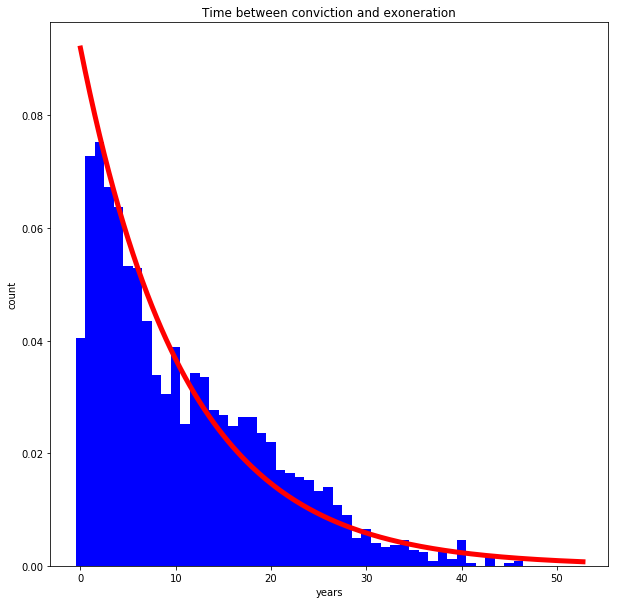

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
df.hist('time_elapsed', bins=np.arange(longest)-0.5, ax=ax,color='b',
       weights = np.ones_like(df['time_elapsed']) / len(df['time_elapsed']))
ax.set_title('Time between conviction and exoneration')
ax.set_xlabel('years')
ax.set_ylabel('count')
ax.grid(False)

ax.plot(t,y,c='r',linewidth=5)

In [51]:
print(longest)

count, division = np.histogram(df['time_elapsed'], bins=np.arange(longest+2)-0.5)

52


In [52]:
len(division)

54

In [53]:
len(count)
count

array([ 98, 176, 182, 163, 154, 129, 128, 105,  82,  74,  94,  61,  83,
        81,  67,  65,  60,  64,  64,  57,  53,  41,  40,  38,  37,  32,
        34,  26,  22,  12,  16,  10,   8,   9,  11,   7,   6,   2,   6,
         3,  11,   1,   0,   4,   0,   1,   2,   0,   0,   0,   0,   0,
         1])

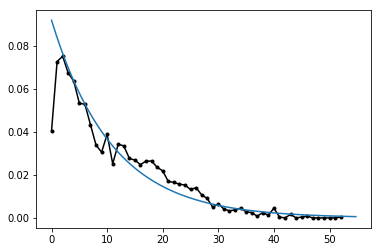

In [62]:
plt.plot(np.arange(longest+1),count / np.sum(count),c='k',marker='.')

lamb = df['time_elapsed'].mean()
t = np.arange(0,55,0.25)
y = expdist(t, lamb)

plt.plot(t,y)

How to sample from this? Can use `np.random.choice`, but this only works for the case in which we have discrete sample space and the probabilities over these sum to 1. In the current case, we have a distribution over a continuous space (which we obtained from some data), so how can we sample from this? 

A good way to go is to obtain the cdf of the distribution. 

In [65]:
# doesn't work!
p=expdist(np.arange(0,longest+1),lamb)
np.random.choice(np.arange(0,longest+1), 
                 p=p)

ValueError: probabilities do not sum to 1

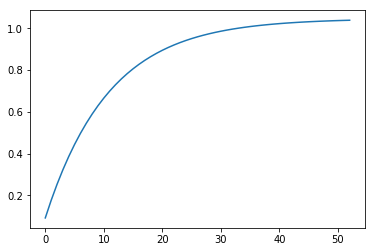

In [70]:
p=expdist(np.arange(0,longest+1),lamb)
cdf = np.cumsum(p)

plt.plot(np.arange(0,longest+1), cdf)

We need the inverse of the cdf. We can obtain this, hopefully, by analytically computing the cdf and then analytically taking the inverse.

\begin{equation}
cdf\left(x\right) = \int_0^x p\left(u\right)\, du
\end{equation}

In the case of the exponential distribution, $p\left(x;\lambda\right) = \lambda^{-1} \exp\left(- x/\lambda\right)$. Then this integral gives

\begin{equation}
cdf\left(x\right) = \lambda^{-1} \int_0^x \exp\left(-u/\lambda\right)\, du = 1 - \exp\left(-x/\lambda\right)
\end{equation}

The inverse of this can be calculated by hand as

\begin{equation}
cdf^{-1}\left(t\right) = - \lambda \log \left(1-t\right)
\end{equation}

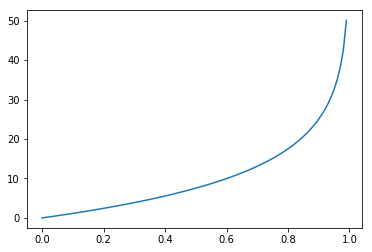

In [74]:
def expinv(t,lamb):
    return(-lamb*np.log(1.-t))

t = np.arange(0,1,0.01)
c = expinv(t,lamb)

plt.plot(t,c)

To apply the inverse transform sampling, simply draw a random number from $U\left(\left[0,1\right]\right)$ and evaluate the inverse cdf at this value to obtain the sample. The samples drawn this way will be exponentially distributed.

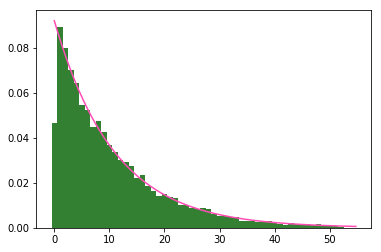

In [111]:
t_sam = np.random.rand(10000,1)
x_sam = expinv(t_sam,lamb)

plt.hist(x_sam, bins=np.arange(0,longest+2)-0.5,density=True,color=(0.2,0.5,0.2))


lamb = df['time_elapsed'].mean()
t = np.arange(0,55,0.25)
y = expdist(t, lamb)

plt.plot(t,y,c=(1, 0.3, 0.7))

In [118]:
expinv(np.random.rand(1,1),lamb)

array([[12.24916151]])

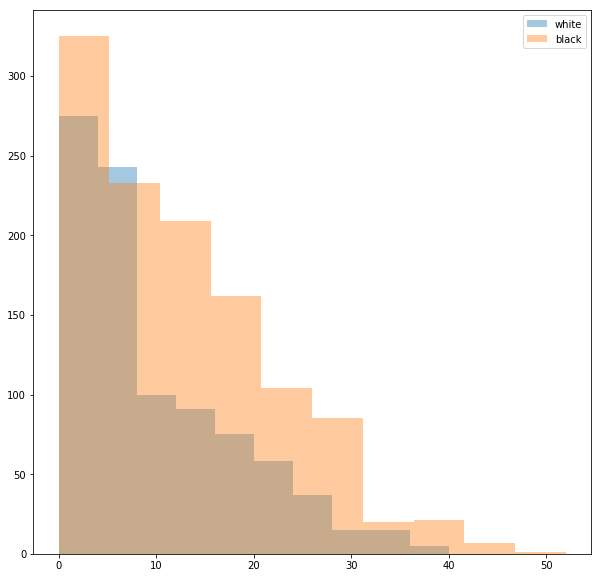

In [30]:
df_white = df[df['race']=='White']
df_black = df[df['race']=='Black']

fig, ax = plt.subplots(figsize=(10,10))
bins = np.arange(0,50,100)
ax.hist(df_white['time_elapsed'],alpha=0.4, label='white')
ax.hist(df_black['time_elapsed'],alpha=0.4, label='black')
plt.legend()
plt.show()

#df_white.hist('time_elapsed',ax=ax)
#df_black.hist('time_elapsed',ax=ax)

In [71]:
df_white.shape

(914, 25)